In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)
from fastai.vision import *
from fastai.metrics import error_rate

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
bs = 16
from pathlib import PosixPath
path_img = PosixPath('data')
fnames = get_image_files(path_img)
print(len(fnames))
fnames[:5]

117


[PosixPath('data/ashes_1.jpg'),
 PosixPath('data/ashes_10.jpg'),
 PosixPath('data/ashes_11.jpg'),
 PosixPath('data/ashes_12.jpg'),
 PosixPath('data/ashes_13.jpg')]

['ashes', 'java', 'luna', 'python']


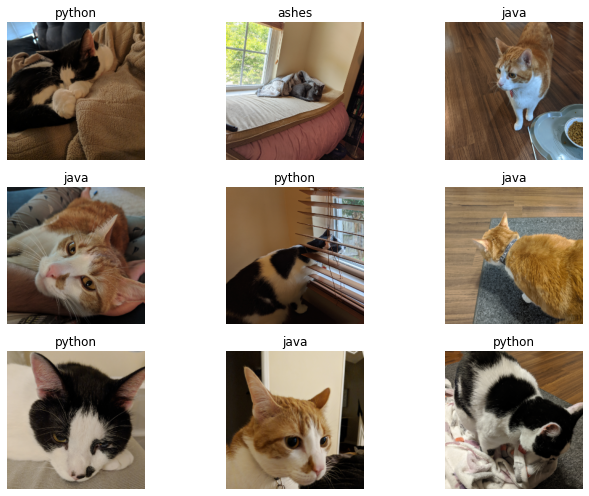

In [3]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat,
                                   ds_tfms=get_transforms(),
                                   size=224, bs=bs).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(10,7))
print(data.classes)

In [4]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4)
learn.export()

epoch,train_loss,valid_loss,error_rate,time
0,2.567609,0.945511,0.434783,01:15
1,1.684793,0.178592,0.043478,00:49
2,1.138985,0.091888,0.043478,00:38
3,0.856995,0.106263,0.043478,00:44


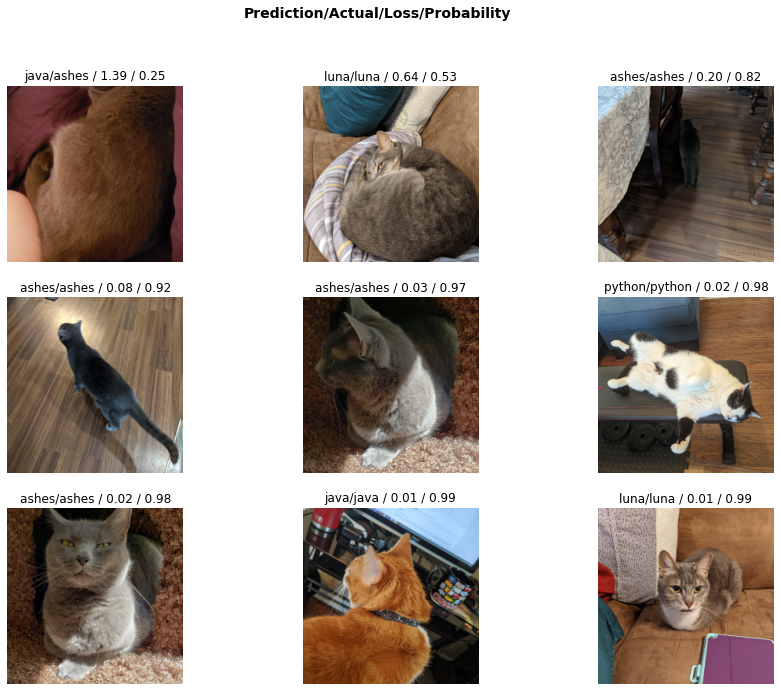

In [5]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

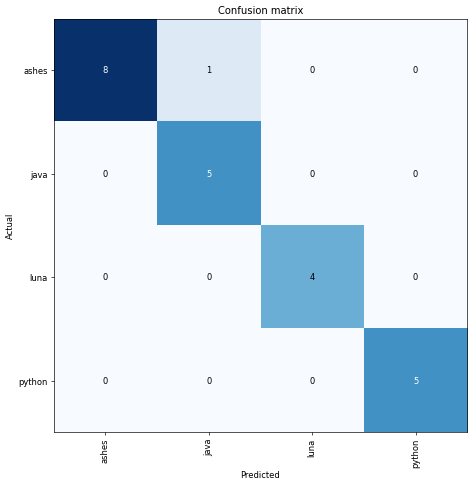

In [6]:
interp.plot_confusion_matrix(figsize=(8, 8), dpi=60)